In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kaoutaraissaoui","key":"5603cd7ddb70daca0cbebad9b12b7297"}'}

In [ ]:
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

 95% 330M/346M [00:01<00:00, 228MB/s]
100% 346M/346M [00:01<00:00, 218MB/s]


In [ ]:
from zipfile import ZipFile
file_name="intel-image-classification.zip"

with ZipFile(file_name, 'r') as zip :
  zip.extractall()
  print('Done')

Done


In [ ]:
import os
import cv2
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plot
from random import randint
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.utils as Utils
import matplotlib.gridspec as gridspec
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model,layers
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.models as Models
import tensorflow.keras.layers as Layers
import tensorflow.keras.optimizers as Optimizer
from keras import regularizers

In [ ]:
    #créer une fonction pour extraire les images des dossiers
    def get_images(directory):
      Images = []
      Labels = []  # 0 pour Building , 1 pour forest, 2 pour glacier, 3 pour mountain, 4 pour Sea , 5 pour Street
      label = 0
      for labels in os.listdir(directory): #chaque label est présenté comme nom de dossier contenant nos images.
      #os.listdir(path) : Cette méthode retourne une liste contenant les noms des entrées du répertoire donné dans le path.
        if labels == 'glacier': #dans le dossier Glacier les images obtiennent le libellé de classe 2
          label = 2
        elif labels == 'sea':
          label = 4
        elif labels == 'buildings':
          label = 0
        elif labels == 'forest':
          label = 1
        elif labels == 'street':
          label = 5
        elif labels == 'mountain':
          label = 3
        for image_file in os.listdir(directory+labels): #Extraction du nom de fichier de l'image du dossier de chaque label de classe
          image = cv2.imread(directory+labels+r'/'+image_file)  #Reading the image (OpenCV)
          '''OpenCV est une bibliothèque graphique libre, initialement développée par Intel, 
          spécialisée dans le traitement d'images en temps réel. c'est une bibliothèque de Python conçue pour résoudre les problèmes de computer vision'''
          '''La méthode cv2.imread () charge une image à partir du fichier spécifié. 
          Si l'image ne peut pas être lue (en raison d'un fichier manquant, d'autorisations incorrectes, 
          d'un format non pris en charge ou non valide), cette méthode renvoie une matrice vide.'''
          image = cv2.resize(image,(150,150)) #Redimensionner l'image, certaines images sont de tailles différentes. (Le redimensionnement est très important)
          Images.append(image) #on ajoute chaque image parcouru dans la liste des images
          Labels.append(label) #on ajoute egalement pour chaque image parcouru son label correspondant 
      return shuffle(Images,Labels,random_state=817328462) #Mélanger le dataset.
      '''En mélangeant nos données, nous nous assurons que chaque point de données crée un changement «indépendant» sur le modèle, 
       sans être biaisé par les mêmes points avant eux. Le shuffle des données sert à réduire la variance et à s'assurer que les modèles restent généraux et moins overfited.
       Nous avons mélangé nos données car elles sont triées par classe. Ici, nous voudrons mélanger pour nous assurer que nos ensembles de train / test / validation sont représentatifs de la distribution globale des données.'''
#on crée une fonction qui retourne la valeur de chaque clé du dictionnaire des labels créé
def get_classlabel(class_code):
  labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
  return labels[class_code]

In [ ]:
Images, Labels = get_images('/content/seg_train/seg_train/') #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels) ##converting the list of labels to numpy array.

In [ ]:
print("Shape of Images:",Images.shape) 
print("Shape of Labels:",Labels.shape)

Shape of Images: (14034, 150, 150, 3)
Shape of Labels: (14034,)


In [ ]:
Images_test, Labels_test = get_images('/content/seg_train/seg_train/') #Extract the test images from the folders.

Images_test = np.array(Images_test) #converting the list of images to numpy array.
Labels_test = np.array(Labels_test) ##converting the list of labels to numpy array.

In [ ]:
print("Shape of Images:",Images_test.shape) 
print("Shape of Labels:",Labels_test.shape)

Shape of Images: (14034, 150, 150, 3)
Shape of Labels: (14034,)


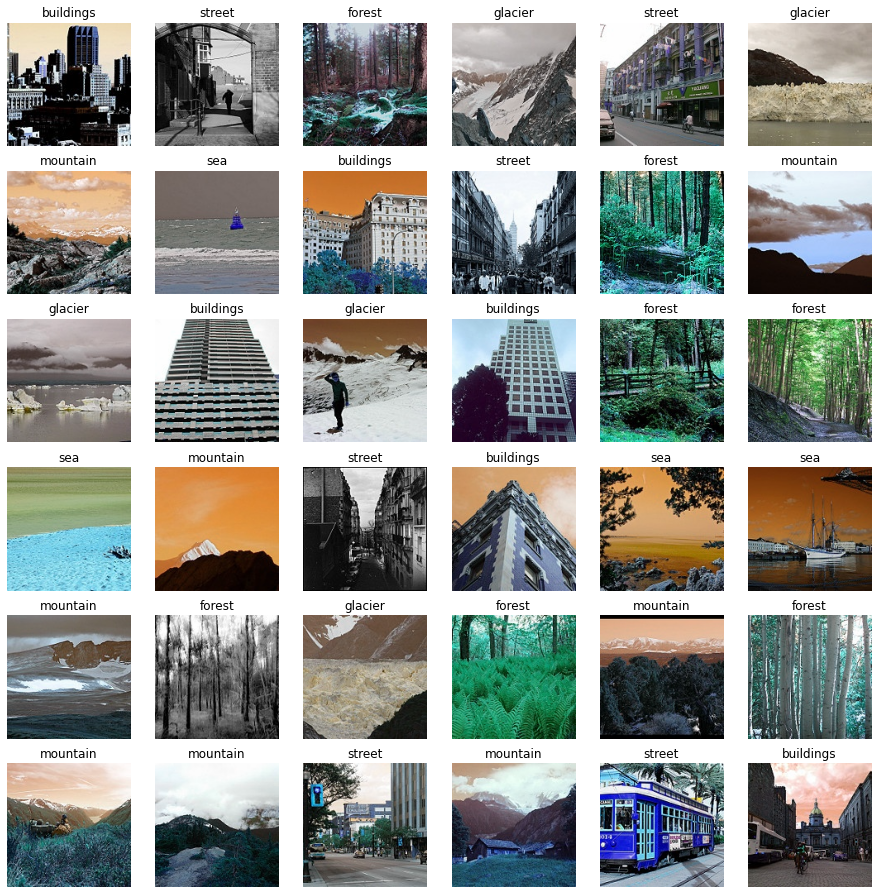

In [ ]:
#Regardons quelques images aléatoires de notre ensemble de dataset
f,ax = plot.subplots(6,6) #présenter sur une même zone graphique plusieurs tracés de résultats (6 images par ligne et 6 par colonne)
f.subplots_adjust(1,0,3,3) #Ajustez la disposition de l'ensemble des images.
for i in range(0,6,1): #parcourir les lignes
    for j in range(0,6,1): #parcourir les colonnes
        rnd_number = randint(0,len(Images)) #on prend une image aléatoire (son indice) de la liste des images
        ax[i,j].imshow(Images[rnd_number]) #on affiche dans la position (i,j) l'image prise
        ax[i,j].set_title(get_classlabel(Labels[rnd_number])) #on définit le titre de l'image comme label
        ax[i,j].axis('off') #masquer les valeurs sur les axes

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 38, 38, 64)        36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 38, 38, 128)      

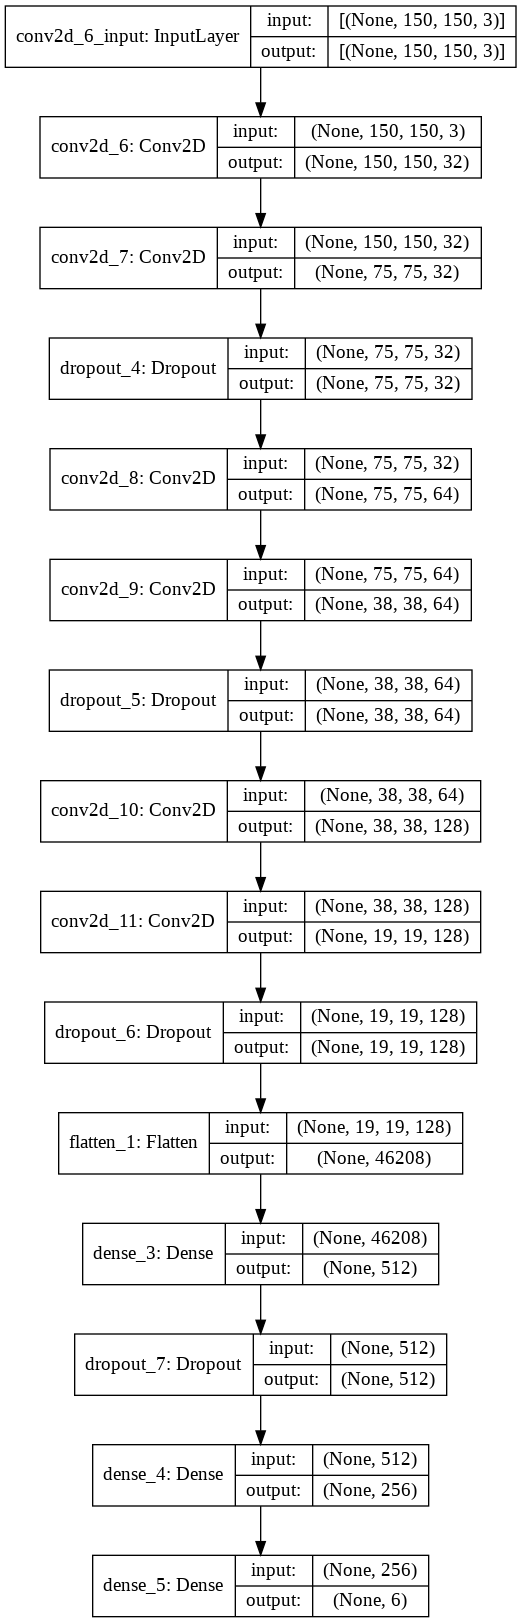

In [ ]:
model = Models.Sequential()

model.add(Layers.Conv2D(32,kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),padding="same", activation='relu',input_shape=(150,150,3)))
model.add(Layers.Conv2D(32,kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001), strides=(2, 2), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Layers.Conv2D(64,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.001), padding="same", activation='relu'))
model.add(Layers.Conv2D(64,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.001), strides=(2, 2), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Layers.Conv2D(128,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.001), padding="same", activation='relu'))
model.add(Layers.Conv2D(128,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.001), strides=(2, 2), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Layers.Flatten())
model.add(Layers.Dense(512,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(256,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Layers.Dense(6,activation='softmax'))


model.summary()
Utils.plot_model(model,to_file='model.png',show_shapes=True)

In [ ]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

trained = model.fit(Images, Labels, epochs=10, 
                    validation_data=(Images_test, Labels_test))

Epoch 1/10
439/439 [==============================] - 29s 64ms/step - loss: 1.6325 - accuracy: 0.6369 - val_loss: 1.3366 - val_accuracy: 0.7875
Epoch 2/10
439/439 [==============================] - 28s 65ms/step - loss: 1.3016 - accuracy: 0.7832 - val_loss: 1.1489 - val_accuracy: 0.8192
Epoch 3/10
439/439 [==============================] - 28s 64ms/step - loss: 1.2131 - accuracy: 0.8081 - val_loss: 1.1332 - val_accuracy: 0.8377
Epoch 4/10
439/439 [==============================] - 28s 63ms/step - loss: 1.1848 - accuracy: 0.8229 - val_loss: 1.1055 - val_accuracy: 0.8454
Epoch 5/10
439/439 [==============================] - 28s 64ms/step - loss: 1.1789 - accuracy: 0.8286 - val_loss: 0.9866 - val_accuracy: 0.8804
Epoch 6/10
439/439 [==============================] - 28s 63ms/step - loss: 1.1208 - accuracy: 0.8386 - val_loss: 1.0119 - val_accuracy: 0.8707
Epoch 7/10
439/439 [==============================] - 28s 63ms/step - loss: 1.0812 - accuracy: 0.8476 - val_loss: 0.9549 - val_accuracy:

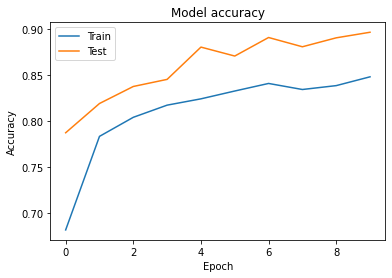

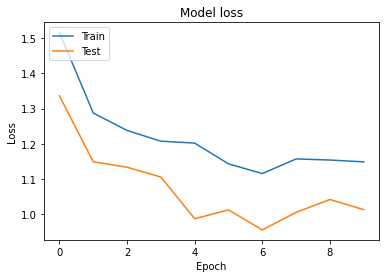

In [ ]:
plot.plot(trained.history['accuracy'])
plot.plot(trained.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [ ]:
test_images,test_labels = get_images('/content/seg_test/seg_test/')
test_images = np.array(test_images)
test_labels = np.array(test_labels)
model.evaluate(test_images,test_labels, verbose=1)

94/94 [==============================] - 1s 13ms/step - loss: 1.5029 - accuracy: 0.7907


[1.5028753280639648, 0.7906666398048401]

In [ ]:
pred_images,no_labels = get_images('/content/seg_pred/')
pred_images = np.array(pred_images)
pred_images.shape

(7301, 150, 150, 3)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


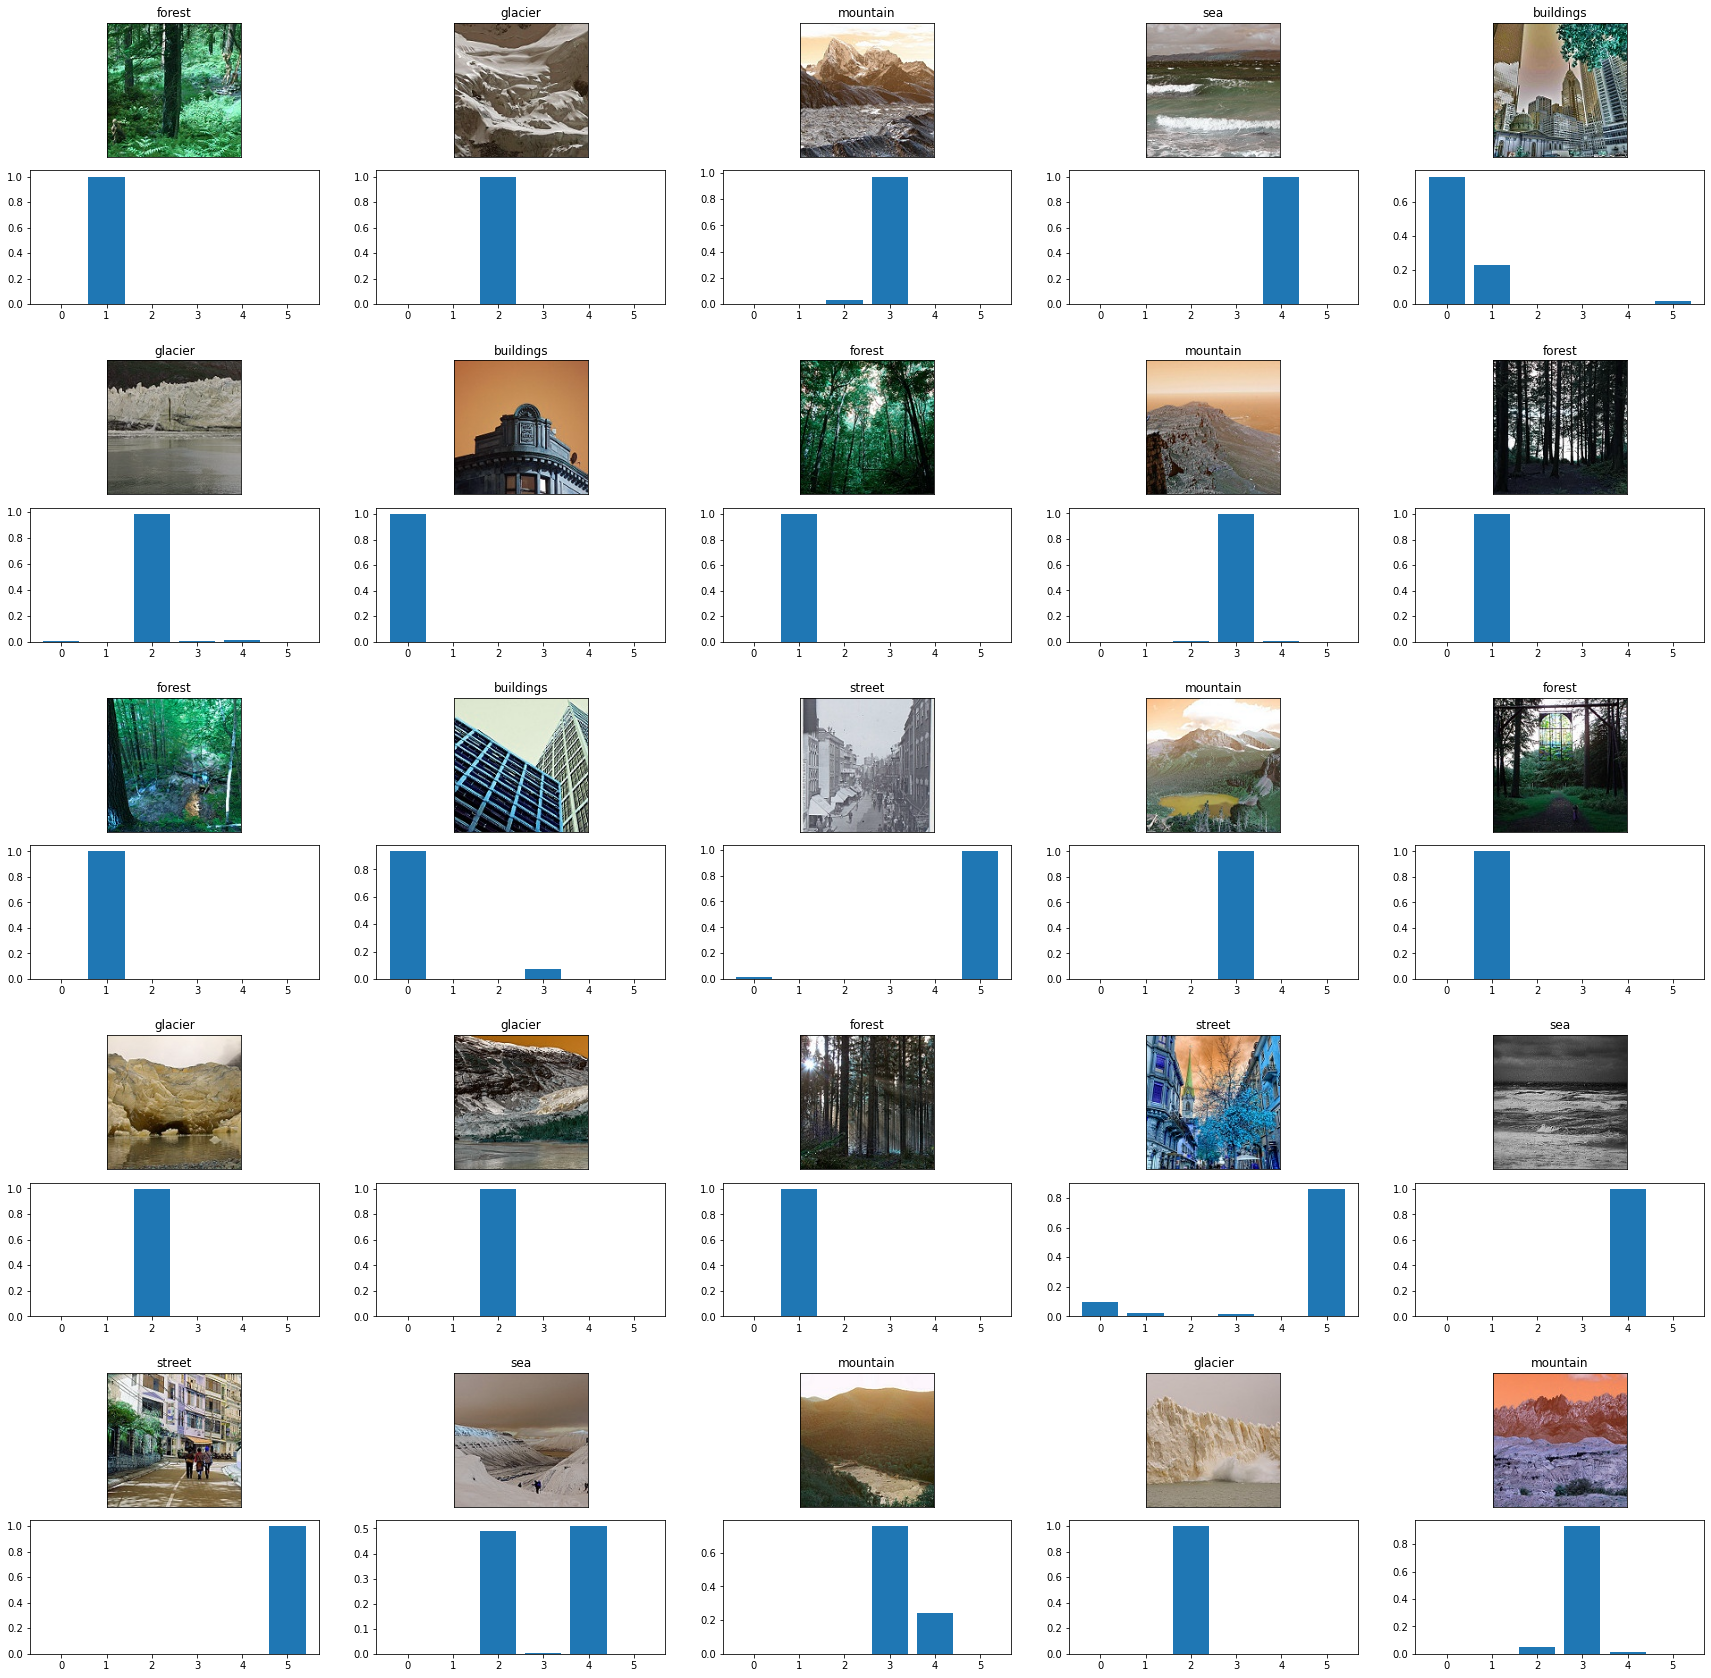

In [ ]:
fig = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_class = get_classlabel(model.predict_classes(pred_image)[0])
    pred_prob = model.predict(pred_image).reshape(6)
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plot.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)


fig.show()

In [ ]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="/content/seg_train/seg_train",target_size=(150,150))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="/content/seg_test/seg_test", target_size=(150,150))

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
vgg_16_model=Sequential() # Création d'un réseau de neurones vide 

# Ajout de la première couche de convolution, suivie d'une couche ReLU
vgg_16_model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same', input_shape=(150,150,3)))
# Ajout de la première couche de bach normalization
vgg_16_model.add(BatchNormalization(momentum = 0.9))
# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
vgg_16_model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
# Ajout de la première couche de pooling
vgg_16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg_16_model.add(Conv2D(filters=128, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(Conv2D(filters=128, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg_16_model.add(Conv2D(filters=256, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(Conv2D(filters=256, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(Conv2D(filters=256, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg_16_model.add(Conv2D(filters=512, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(Conv2D(filters=512, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(Conv2D(filters=512, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg_16_model.add(Conv2D(filters=512, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(Conv2D(filters=512, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(Conv2D(filters=512, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001), activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg_16_model.add(Flatten()) # Conversion des matrices 3D en vecteur 1D
# Ajout de la première couche fully-connected, suivie d'une couche ReLU
vgg_16_model.add(Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
# Ajout de la deuxième couche fully-connected, suivie d'une couche ReLU
vgg_16_model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
# Ajout de la dernière couche fully-connected qui permet de classifier
vgg_16_model.add(Dense(6, activation='softmax'))

In [ ]:
from keras.optimizers import Adam
vgg_16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 150, 150, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 64)      256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 150, 150, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 128)      

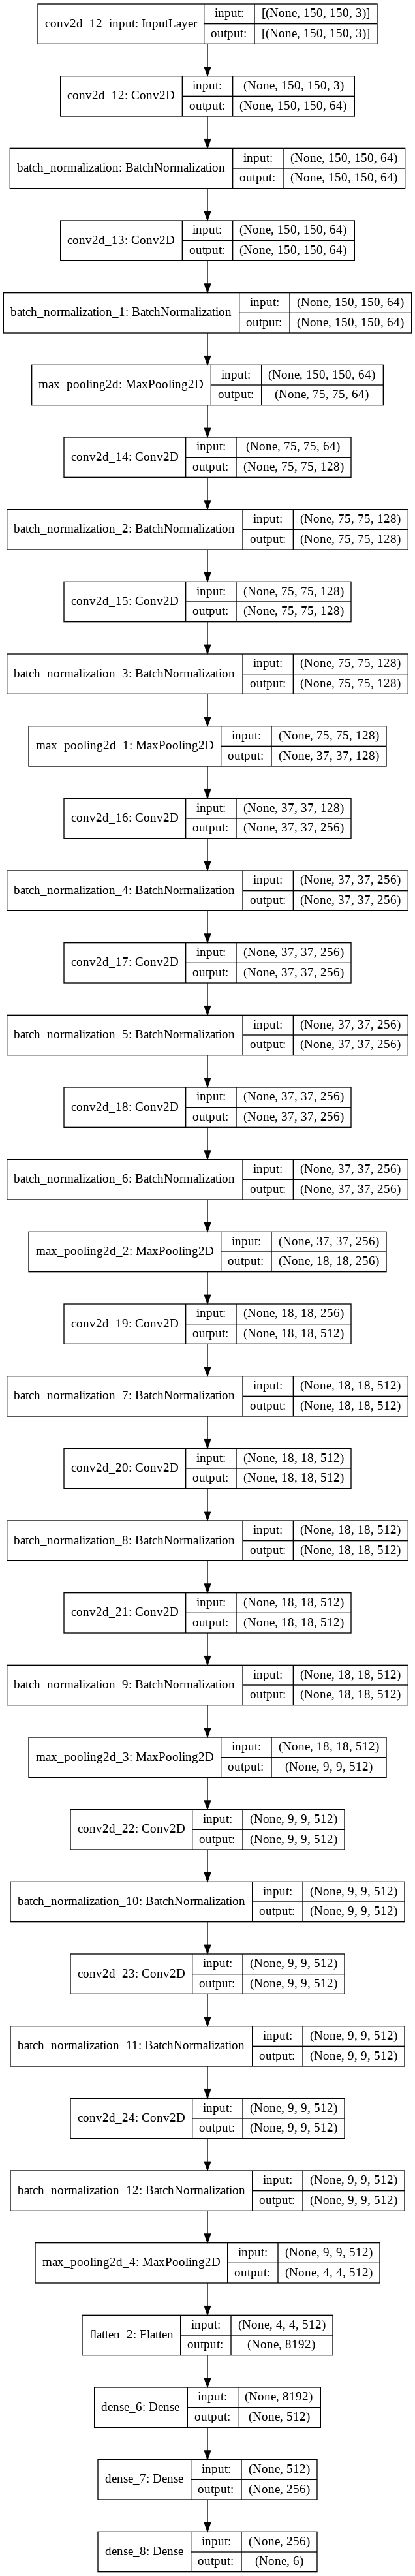

In [ ]:
vgg_16_model.summary()
Utils.plot_model(vgg_16_model,to_file='model.png',show_shapes=True)

In [ ]:
vgg_16_model.fit_generator(generator = traindata, steps_per_epoch = 20, validation_data = testdata,validation_steps = 10, epochs = 50)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
20/20 [==============================] - 11s 318ms/step - loss: 11.2963 - accuracy: 0.2487 - val_loss: 15.2030 - val_accuracy: 0.2812
Epoch 2/50
20/20 [==============================] - 6s 300ms/step - loss: 7.5847 - accuracy: 0.3977 - val_loss: 8.1845 - val_accuracy: 0.4563
Epoch 3/50
20/20 [==============================] - 6s 302ms/step - loss: 7.3444 - accuracy: 0.4711 - val_loss: 7.2742 - val_accuracy: 0.4250
Epoch 4/50
20/20 [==============================] - 6s 299ms/step - loss: 7.0357 - accuracy: 0.4879 - val_loss: 6.8564 - val_accuracy: 0.4781
Epoch 5/50
20/20 [==============================] - 6s 296ms/step - loss: 6.9015 - accuracy: 0.5268 - val_loss: 6.5338 - val_accuracy: 0.5781
Epoch 6/50
20/20 [==============================] - 6s 295ms/step - loss: 6.6962 - accuracy: 0.4979 - val_loss: 6.4695 - val_accuracy: 0.5688
Epoch 7/50
20/20 [==============================] - 6s 291ms/step - loss: 6.4053 - accuracy: 0.5675 - val_loss: 6.5821 - val_accuracy: 0.5281
Epo

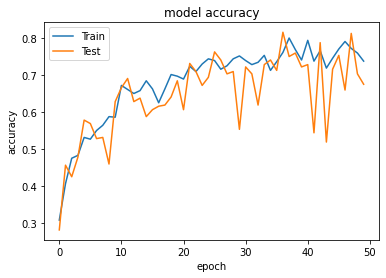

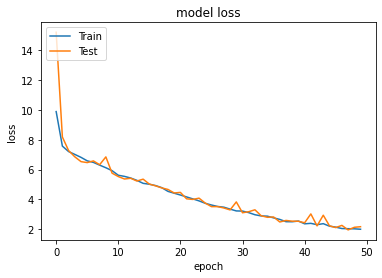

In [ ]:
import matplotlib.pyplot as plt
plt.plot(vgg_16_model.history.history['accuracy'])
plt.plot(vgg_16_model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(vgg_16_model.history.history['loss'])
plt.plot(vgg_16_model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from keras.utils import to_categorical
test_images,test_labels = get_images('/content/seg_test/seg_test/')

test_label = to_categorical(test_labels)
test_images = np.array(test_images)
test_labels = np.array(test_label)

vgg_16_model.evaluate(test_images,test_labels, verbose=1)

94/94 [==============================] - 8s 79ms/step - loss: 2.4424 - accuracy: 0.5793


[2.4424057006835938, 0.5793333053588867]

In [ ]:
pred_images,no_labels = get_images('/content/seg_pred/')
pred_images = np.array(pred_images)
pred_images.shape

(7301, 150, 150, 3)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


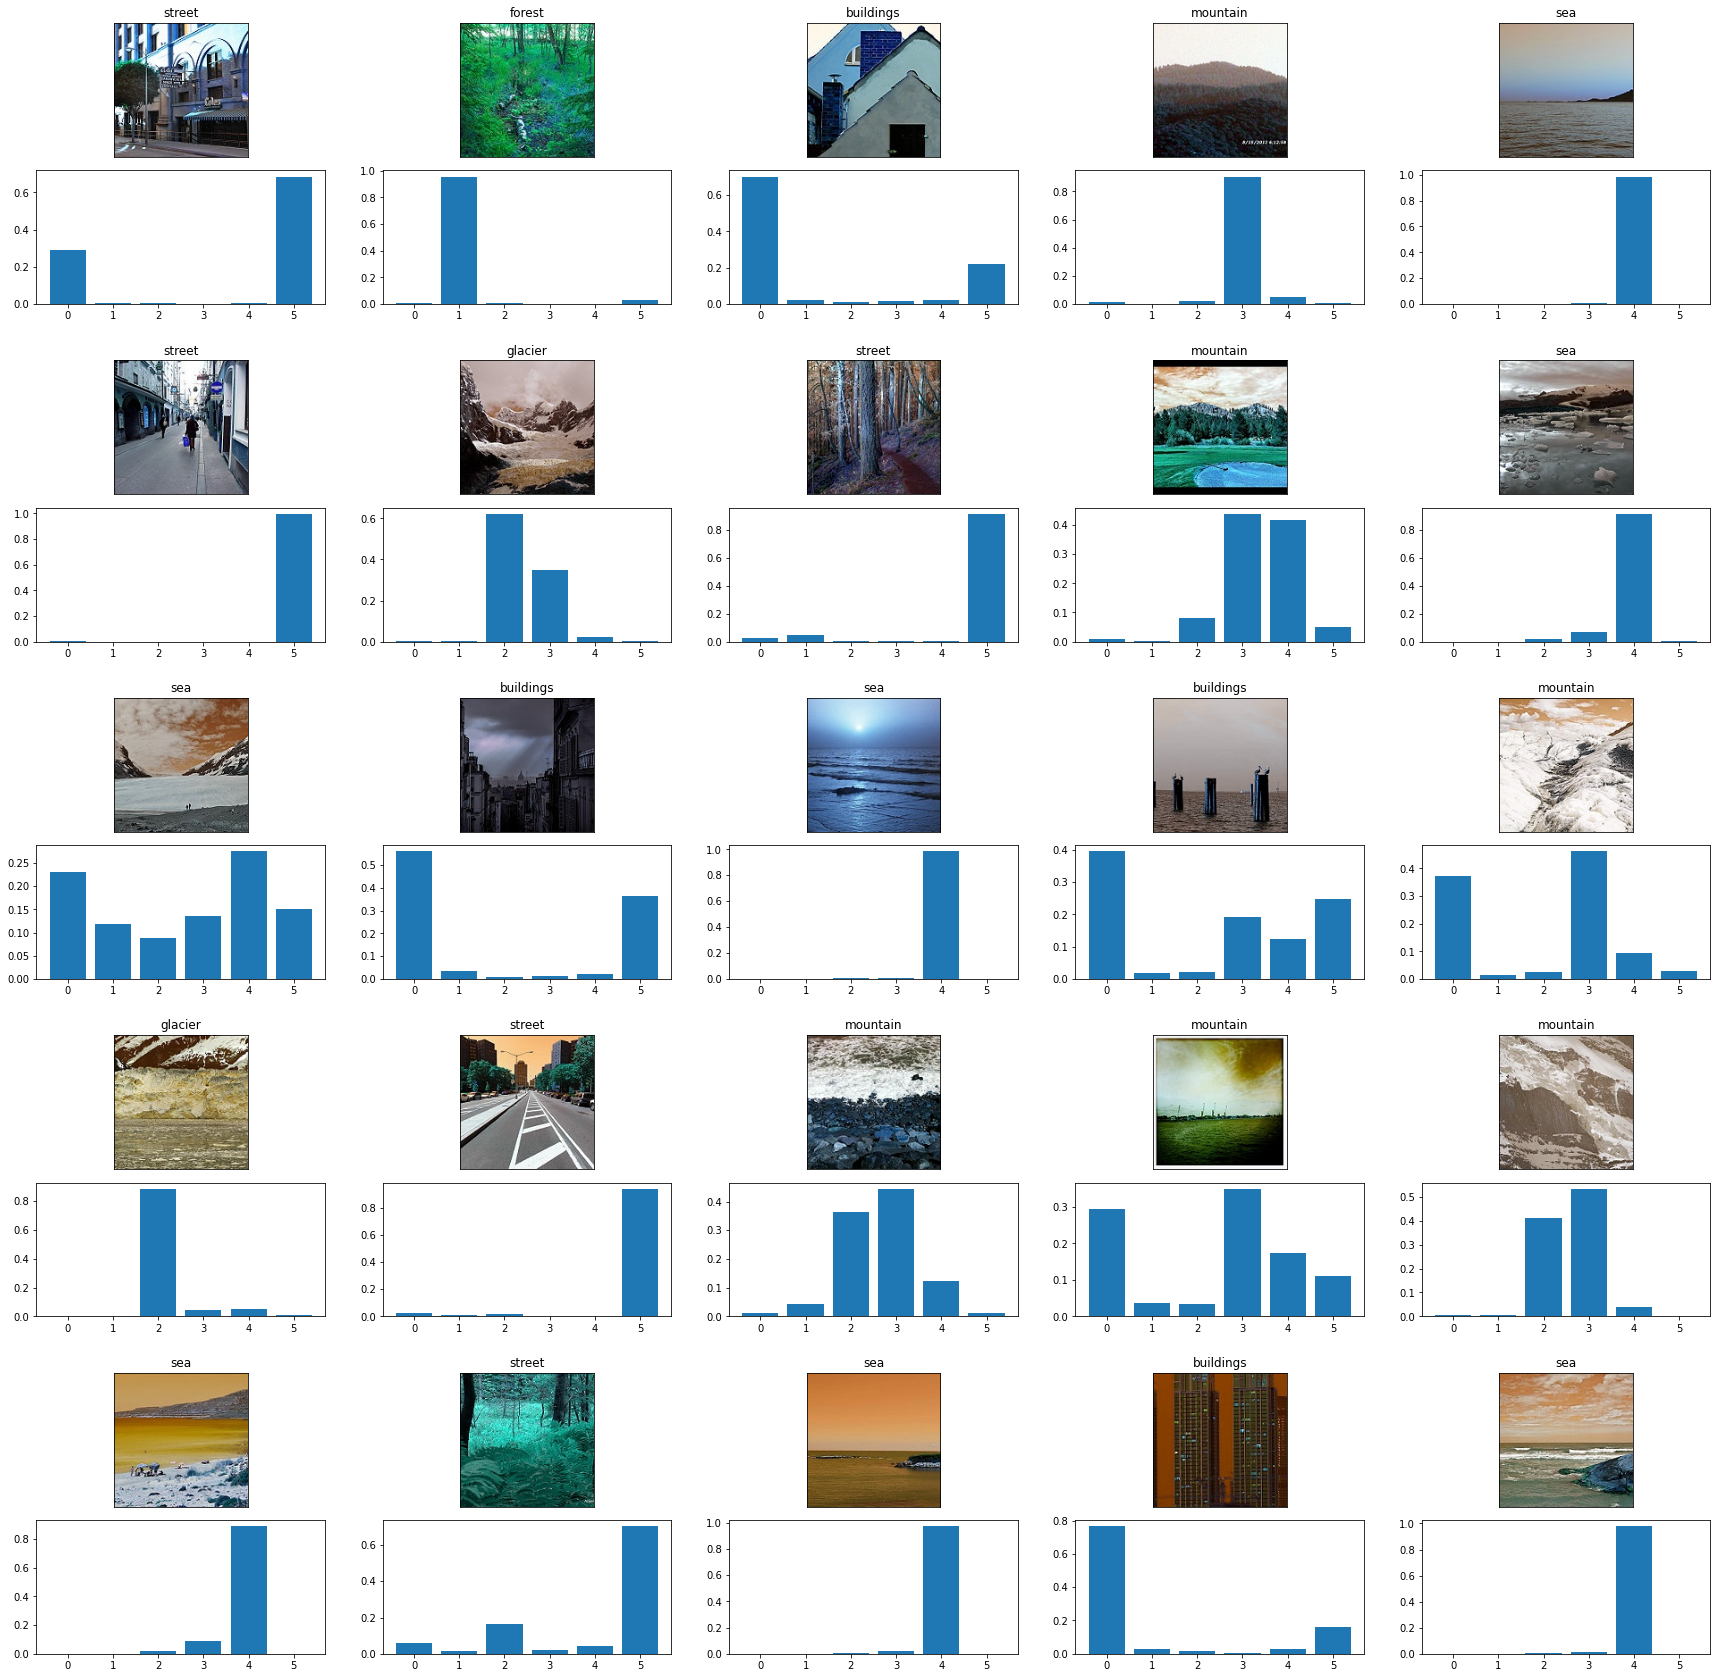

In [ ]:
fig = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_class = get_classlabel(vgg_16_model.predict_classes(pred_image)[0])
    pred_prob = vgg_16_model.predict(pred_image).reshape(6)
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plot.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)


fig.show()

In [ ]:
from tensorflow.keras.applications import InceptionV3
# Charger inceptionV3 pré-entraîné sur ImageNet et sans les couches fully-connected
pre_trained_model=InceptionV3(include_top=False,input_shape=(150,150,3))
for layer in pre_trained_model.layers:
    layer.trainable = False

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
# On n'utilise que des couches comprenant et au-dessus de "mixed9"
last_layer=pre_trained_model.get_layer('mixed9')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output 

last layer output shape:  (None, 3, 3, 2048)


In [ ]:
from tensorflow.keras.optimizers import RMSprop,Adam
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau

In [ ]:
# aplatir la couche de sortie à 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Ajoutez une couche entièrement connectée avec 1024 unités cachées et activation ReLU
x = tf.keras.layers.Dense(units = 1024, activation = tf.nn.relu)(x)
# Ajouter un taux d'abandon de 0,6
x = tf.keras.layers.Dropout(0.6)(x)
# Ajouter une dernière couche softmax pour la classification
x = tf.keras.layers.Dense  (6, activation = tf.nn.softmax)(x)

model_v3 = tf.keras.Model( pre_trained_model.input, x)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=1,
                                            verbose=1,
                                            factor=0.25,
                                            min_lr=0.000003)

In [ ]:
model_v3.compile(optimizer = tf.keras.optimizers.Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
history = model_v3.fit(
            traindata,
            verbose=1,
            validation_data = testdata,
            epochs = 20)

Epoch 1/20
439/439 [==============================] - 25s 50ms/step - loss: 12.2570 - accuracy: 0.4125 - val_loss: 1.2345 - val_accuracy: 0.5280
Epoch 2/20
439/439 [==============================] - 20s 47ms/step - loss: 1.3478 - accuracy: 0.4936 - val_loss: 1.1594 - val_accuracy: 0.5693
Epoch 3/20
439/439 [==============================] - 21s 47ms/step - loss: 1.2421 - accuracy: 0.5229 - val_loss: 1.1139 - val_accuracy: 0.5690
Epoch 4/20
439/439 [==============================] - 21s 47ms/step - loss: 1.1588 - accuracy: 0.5475 - val_loss: 1.1072 - val_accuracy: 0.5653
Epoch 5/20
439/439 [==============================] - 21s 48ms/step - loss: 1.1262 - accuracy: 0.5580 - val_loss: 1.0724 - val_accuracy: 0.5890
Epoch 6/20
439/439 [==============================] - 21s 48ms/step - loss: 1.1019 - accuracy: 0.5633 - val_loss: 1.0399 - val_accuracy: 0.6173
Epoch 7/20
439/439 [==============================] - 21s 48ms/step - loss: 1.0395 - accuracy: 0.5917 - val_loss: 1.0463 - val_accuracy

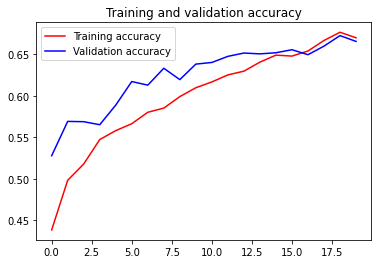

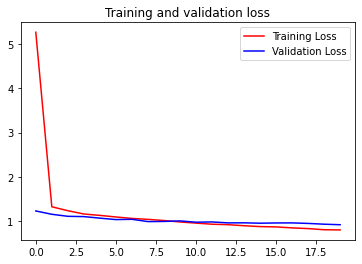

In [ ]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_images,test_labels = get_images('/content/seg_test/seg_test/')

test_label = to_categorical(test_labels)
test_images = np.array(test_images)
test_labels = np.array(test_label)

model_v3.evaluate(test_images,test_labels, verbose=1)

94/94 [==============================] - 4s 28ms/step - loss: 0.9465 - accuracy: 0.6643


[0.946514904499054, 0.6643333435058594]